# Introducción

#### En el siguiente cuaderno se presenta la implementacion de una red neuronal capaz de identificar numeros manuscritos, para el desarrollo fueron utilizados los datos correspondientes al dataset Mnist alojado en keras. Inicialmente se realizó un procesado de las imagenes y de sus respectivas etiquetas de forma que podamos contribuir al modelo con datos que faciliten y optimicen sus procesos de aprendizaje.

#### Una vez definido el procesamiento de los datos, la forma de las entradas y las salidas; se definió el modelo de red neuronal que se utilizaria, dicho modelo cuenta con 6 capas con numeros de neuronas variables entre las 256 y las 16, el entrenamiento de la red neuronal se realizo en lotes(batches) lo cual mostró un comportamiento particular en el proceso de entrenamiento. 

#### Finalmente, luego de varias los parametros, la cantidad de iteraciones, cambiar el dropout, se obtuvo una precision del 92% sin embargo al momento de realizar las pruebas se identificó que el modelo parece presentar un sesgo pues muchas imagenes que intento predecir tomaron este valor aparentemente arbitrario ante problemas no conocidos. Con el fin de mejorar los resultados se implementa un segundo modelo esta vez haciendo uso de procesos de convolucion y/o funciones de activacion no lineales

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt
import math
import random

tf.compat.v1.disable_eager_execution()

In [3]:
from tensorflow import keras

mnist = keras.datasets.mnist

(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

#### Para realizar las pruebas tomaremos 10 imagenes del dataset para verificar la precision del mismo observando las imagenes a evaluar estas se almacenaran en el arreglo val_images y val_labels

In [4]:
val_images = test_images[-10:,:,:]
val_labels = test_labels[-10:]
test_images = test_images[:-10,:,:]
test_labels = test_labels[:-10]

### Visualizando algunas imagenes del conjunto disponible

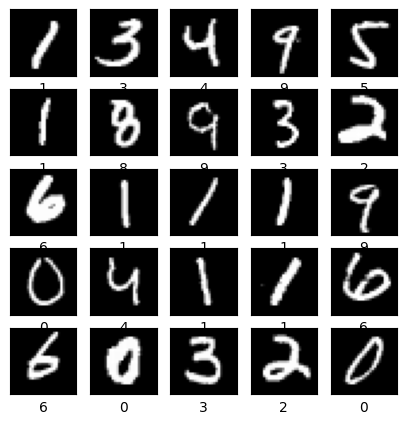

In [5]:
plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    k = random.randint(0, len(train_images))
    plt.imshow(train_images[k], cmap=plt.cm.gray)
    plt.xlabel(train_labels[k])
plt.show()

# Depuración / Pre-Procesamiento de los datos

#### Se realiza la division de los datos con el fin de que solo ocupen valores 0 o 1, en otras palabras imagenes en blanco y negro

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

#### Con el animo de contribuir con el modelo es necesario normalizar las salidas o etiquetas, en este caso son numeros entre 0y9 por lo que podrian interpretarse como 10 categorias las cuales se plasman en un arreglo de 10 posiciones donde a cada categoria(digito) le corresponde un arreglo con todas las posiciones en 0 salvo la posicion correspondiente 

In [7]:
def oneHotTarget(targetColumn):
    train_labels_aux = np.array(targetColumn).astype(int)
    labels_OH = np.zeros((train_labels_aux.size, train_labels_aux.max()+1))
    labels_OH[np.arange(train_labels_aux.size), train_labels_aux] = 1
    return labels_OH
    



train_labels_OH = oneHotTarget(train_labels)
test_labels_OH = oneHotTarget(test_labels)



##### Es necesario convertir las columnas de labels en one-hot
print(train_labels[0])
print(train_labels_OH[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Definición / implementación del modelo

In [8]:
print(train_images[0].shape)

(28, 28)


#### Verificamos las dimensiones de las imagenes y las multiplicamos para conocer el tamaño de las entradas, es importante tener en cuenta que para este modelo es necesario convertir las entradas en arreglos unidimensionales del tamaño obtenido por la multiplicacion de sus filas y columnas. Tambien se define el tamaño de la salida que de acuerdo con el proceso realizado en el paso anterior corresponde a 10 por la codificacion de las etiquetas.

#### Adicionalmente se crea el tensor correspondiente al control del rango de dropout.

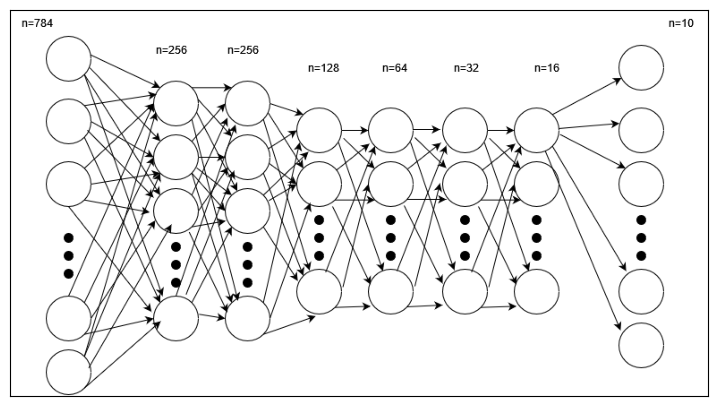

In [44]:
plt.figure(figsize=(9,10))
rnn = Image.open('modelo ann.png')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(rnn)
plt.show()

In [9]:
X = tf.compat.v1.placeholder("float",[None, 784]) ### 28x28
Y = tf.compat.v1.placeholder("float",[None, 10]) ### los parametros indican el tipo de datos que contendra el tensor
                                                 ### y las dimensiones
                                                 ### None significa ilimitado. [numero de entradas, de tamaño]
keep_prob = tf.compat.v1.placeholder(tf.float32)

#### Se definieron 2 diccionarios de tensores correspondientes a los pesos y los bias que son los valores a calcular y refinar en cada iteracion que realice el modelo en el proceso de entrenamiento, notamos que cada uno de los tensores tiene medidas diferente, esto hace referencia a la cantidad de neuronas que sera utilizada en cada una de las capas definidas en las siguientes celdas

In [10]:
wlst=['w1','w2','w3','w4','w5','w6','out']
biaslst=['b1','b2','b3','b4','b5','b6','out']

w = {
    'w1':tf.Variable(tf.random.truncated_normal([784,256], stddev=0.1)),
    'w2':tf.Variable(tf.random.truncated_normal([256,256], stddev=0.1)),
    'w3':tf.Variable(tf.random.truncated_normal([256,128], stddev=0.1)),
    'w4':tf.Variable(tf.random.truncated_normal([128,64], stddev=0.1)),
    'w5':tf.Variable(tf.random.truncated_normal([64,32], stddev=0.1)),
    'w6':tf.Variable(tf.random.truncated_normal([32,16], stddev=0.1)),
    'out':tf.Variable(tf.random.truncated_normal([16,10], stddev=0.1)),
}

In [11]:
bias = {
    'b1': tf.Variable(tf.constant(0.1, shape=[256])),
    'b2': tf.Variable(tf.constant(0.1, shape=[256])),
    'b3': tf.Variable(tf.constant(0.1, shape=[128])),
    'b4': tf.Variable(tf.constant(0.1, shape=[64])),
    'b5': tf.Variable(tf.constant(0.1, shape=[32])),
    'b6': tf.Variable(tf.constant(0.1, shape=[16])),
    'out': tf.Variable(tf.constant(0.1, shape=[10]))
}

In [12]:
###capas

capa_1 = tf.add(tf.matmul(X, w['w1']), bias['b1'])
capa_2 = tf.add(tf.matmul(capa_1, w['w2']), bias['b2'])
capa_3 = tf.add(tf.matmul(capa_2, w['w3']), bias['b3'])
capa_4 = tf.add(tf.matmul(capa_3, w['w4']), bias['b4'])
capa_5 = tf.add(tf.matmul(capa_4, w['w5']), bias['b5'])
capa_6 = tf.add(tf.matmul(capa_5, w['w6']), bias['b6'])
capa_drop = tf.nn.dropout(capa_6, keep_prob)
capa_output = tf.matmul(capa_6, w['out']) + bias['out']

#### Es necesario definir la funcion de perdida con el fin de evaluar de forma precisa el comportamiento de la red al momento de entrenar, para este caso se presenta la funcion cross_entropy no obstante en primeras experimentaciones se identifico que el modelo quizas no era tan preciso como se pensaba por lo que se optó por utilizar otra funcion de perdida ** insertar** 

In [13]:
cross_entropy = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(
                        labels=Y, logits = capa_output
                    )
                )
train_step = tf.compat.v1.train.AdamOptimizer(0.00001).minimize(cross_entropy)

# Entrenamiento del modelo

In [14]:
pred_correctas = tf.equal(tf.argmax(capa_output, 1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(pred_correctas, tf.float32))

In [15]:
init = tf.compat.v1.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)

#### El proceso de entrenamiento en batches se basa en seccionar el conjunto total de datos de entrenamiento en un numero arbitratrio de elementos, acto seguido y de forma aleatoria se selecciona uno de los subconjuntos y se realiza el entrenamiento del modelo, todo esto para cada iteracion. Cabe resaltar que la cantidad de iteraciones tambien puede contribuir a la perdida de precision del modelo. Asi mismo se intenta el ejercicio de entrenar el modelo sin particionar el dataset y disminuyendo la cantidad de iteraciones en busqueda de mejores resultados en la evaluación

In [16]:
### entrenamiento en batches (bloques)
learning_rate = 1e-4
n_iter = 10000
batch_size = 256
dropout = 0.3

cantidad_batches = math.ceil(len(train_images)/batch_size)
train_images_plain = []

for i in range(len(train_images)):
    train_images_plain.append(train_images[i].flatten())


train_images_batch = np.array_split(train_images_plain, cantidad_batches)
train_labels_batch = np.array_split(train_labels_OH, cantidad_batches)


idx = np.arange(0 , len(train_images_batch))
outputs_loss=[]
outputs_acc=[]
itera=[]

for i in range(n_iter):
    np.random.shuffle(idx)
    k=idx[0]
    batch_x = train_images_batch[k]
    batch_y = train_labels_batch[k]
    sess.run(train_step, feed_dict={
        X:batch_x, Y:batch_y, keep_prob:dropout
    })
    
    if i%500 == 0:
        minibatch_loss, minibatch_accuracy = sess.run(
            [cross_entropy, accuracy],
            feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0}
            )
        val = [minibatch_loss,minibatch_accuracy]
        outputs_loss.append(val[0])
        outputs_acc.append(val[1])
        itera.append(i)
        
        print("Iter: ",str(i),"\t| Loss =",str(minibatch_loss),"\t| Accuracy =",str(minibatch_accuracy))

Iter:  0 	| Loss = 2.3313487 	| Accuracy = 0.08235294
Iter:  500 	| Loss = 1.5391095 	| Accuracy = 0.58203125
Iter:  1000 	| Loss = 0.9563483 	| Accuracy = 0.76953125
Iter:  1500 	| Loss = 0.71808845 	| Accuracy = 0.8039216
Iter:  2000 	| Loss = 0.5843232 	| Accuracy = 0.83984375
Iter:  2500 	| Loss = 0.54150295 	| Accuracy = 0.85490197
Iter:  3000 	| Loss = 0.3821045 	| Accuracy = 0.8862745
Iter:  3500 	| Loss = 0.4262028 	| Accuracy = 0.88671875
Iter:  4000 	| Loss = 0.63882715 	| Accuracy = 0.84375
Iter:  4500 	| Loss = 0.2137761 	| Accuracy = 0.9411765
Iter:  5000 	| Loss = 0.3392076 	| Accuracy = 0.8828125
Iter:  5500 	| Loss = 0.26856056 	| Accuracy = 0.90588236
Iter:  6000 	| Loss = 0.46691394 	| Accuracy = 0.8509804
Iter:  6500 	| Loss = 0.36758706 	| Accuracy = 0.8901961
Iter:  7000 	| Loss = 0.30143458 	| Accuracy = 0.9019608
Iter:  7500 	| Loss = 0.5752704 	| Accuracy = 0.8515625
Iter:  8000 	| Loss = 0.309514 	| Accuracy = 0.92156863
Iter:  8500 	| Loss = 0.25214913 	| Accu

#### Observando la tabla anterior vemos como los presentan crecimiento hasta un punto determinado en el cual empiezan a fluctuar, esta fluctuacion es producto de la ultilizacion del entrenamiento en batch

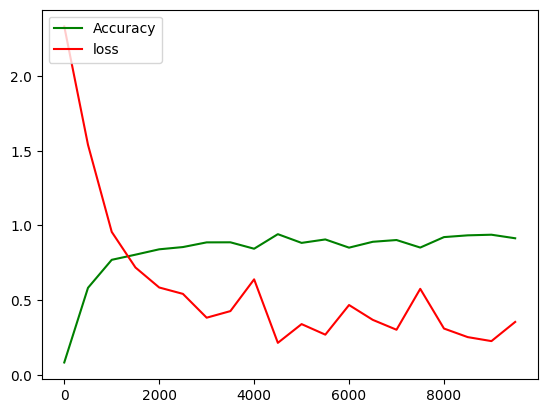

In [17]:
fig, ax = plt.subplots()

ax.plot(itera,outputs_acc,color = 'green', label = 'Accuracy')
ax.plot(itera,outputs_loss, color = 'red', label = 'loss')
ax.legend(loc = 'upper left')
plt.show()

In [18]:
test_images_plain =[]
for i in range(len(test_images)):
    test_images_plain.append(test_images[i].flatten())
    

test_accuracy = sess.run(accuracy, feed_dict={X: test_images_plain, Y: test_labels_OH, keep_prob:1.0})
print("\nAccuracy on test set:", test_accuracy)


Accuracy on test set: 0.9151151


# Pruebas con datos reales

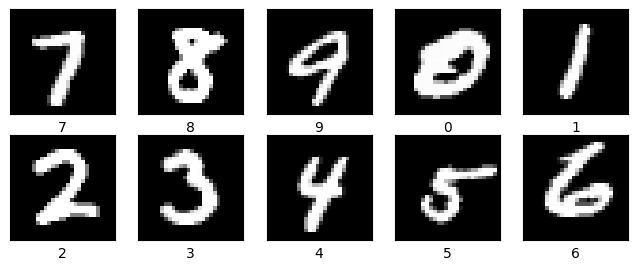

In [19]:
plt.figure(figsize=(8,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    k = random.randint(0, len(train_images))
    plt.imshow(val_images[i], cmap=plt.cm.gray)
    plt.xlabel(val_labels[i])
plt.show()

In [20]:
for i in range(len(val_images)):
    prediction = sess.run(tf.argmax(capa_output, 1), feed_dict={X: [val_images[i].flatten()]})
    print ("Prediccion de la imagen de prueba", np.squeeze(prediction))
    print ("Valor real tomada de las etiquetas: ",val_labels[i])

Prediccion de la imagen de prueba 7
Valor real tomada de las etiquetas:  7
Prediccion de la imagen de prueba 8
Valor real tomada de las etiquetas:  8
Prediccion de la imagen de prueba 9
Valor real tomada de las etiquetas:  9
Prediccion de la imagen de prueba 0
Valor real tomada de las etiquetas:  0
Prediccion de la imagen de prueba 1
Valor real tomada de las etiquetas:  1
Prediccion de la imagen de prueba 2
Valor real tomada de las etiquetas:  2
Prediccion de la imagen de prueba 3
Valor real tomada de las etiquetas:  3
Prediccion de la imagen de prueba 4
Valor real tomada de las etiquetas:  4
Prediccion de la imagen de prueba 5
Valor real tomada de las etiquetas:  5
Prediccion de la imagen de prueba 6
Valor real tomada de las etiquetas:  6


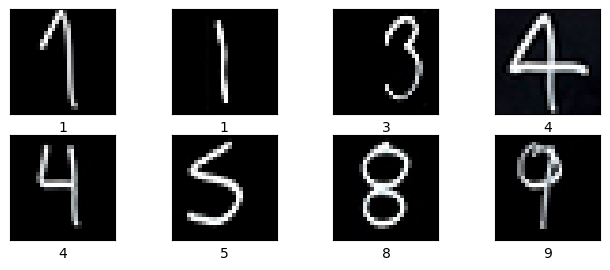

In [29]:
names = ['1m','1v2m','3m','4V1m','4V2m','5m','8m','9m']
values = [1,1,3,4,4,5,8,9]
imgs = []
inverts1 = []
inverts2 = []
for name in names:
    imgs.append(Image.open(name+'.jpg'))


for img in imgs:
    invertA = ImageOps.invert(img.convert('RGB'))
    invertB = np.invert(img.convert('L'))
    inverts1.append(invertA)
    inverts2.append(invertB)
    

imgs = inverts1
    

plt.figure(figsize=(8,3))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    k = random.randint(0, len(train_images))
    plt.imshow(imgs[i], cmap=plt.cm.gray)
    plt.xlabel(values[i])
plt.show()

In [32]:
for i in range(len(imgs)):
    prediction = sess.run(tf.argmax(capa_output, 1), feed_dict={X: [inverts2[i].ravel()]})
    valor='No acertado'
    
    if(np.squeeze(prediction) == values[i]):
        valor = 'Acertado'
    
    print ("Prediccion de la imagen de prueba", np.squeeze(prediction), valor)
    print ("Valor real tomada de las etiquetas: ",values[i])
    print ("-------------------------------------------------------------------------")

Prediccion de la imagen de prueba 2 No acertado
Valor real tomada de las etiquetas:  1
-------------------------------------------------------------------------
Prediccion de la imagen de prueba 1 Acertado
Valor real tomada de las etiquetas:  1
-------------------------------------------------------------------------
Prediccion de la imagen de prueba 0 No acertado
Valor real tomada de las etiquetas:  3
-------------------------------------------------------------------------
Prediccion de la imagen de prueba 2 No acertado
Valor real tomada de las etiquetas:  4
-------------------------------------------------------------------------
Prediccion de la imagen de prueba 4 Acertado
Valor real tomada de las etiquetas:  4
-------------------------------------------------------------------------
Prediccion de la imagen de prueba 3 No acertado
Valor real tomada de las etiquetas:  5
-------------------------------------------------------------------------
Prediccion de la imagen de prueba 8 Acer

# Conclusión

#### A pesar de que se generó un modelo con unos resultados de precisión del 92% vemos que con unos datos que varian ya que los digitos tienen trazos mas delgados solo acerto 3 de 8 es decir una precisión menor al 50% sin embargo, al aplicarlo sobre las imagenes que se extrajeron al inicio acerto el 100% de las imagenes. 

#### Un posible trabajo futuro seria recopilar e incluir al conjunto de datos digitos manuscritos mas delgados con el fin de que el conjunto de datos aumente su variedad alimentando asi los modelos con mas cantidad de datos.